In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

In [2]:
class Bandit:

    '''
    Description :
    bandit_size  =(no_of_bandits,no_of_arms)
    q_start_dist =(mean,variance) of distribution from which true rewards are sampled
    reward_std =  standard deviation of rewards of arm 
    '''

    def __init__(self,bandit_size=(2000,10),q_star_dist=(0,1),reward_std=1):

        self.no_of_bandits = bandit_size[0];
        self.no_of_arms = bandit_size[1];
        self.bandit_size = bandit_size;
        self.reward_std = reward_std;
        self.q_star = np.random.normal(q_star_dist[0],q_star_dist[1],bandit_size);
        
    def pull(self,arms):
        
        index_arms = arms;
        index_bandits = np.arange(self.no_of_bandits);
        
        assert np.size(arms) == self.no_of_bandits
        
        reward=np.random.normal(self.q_star,self.reward_std,self.bandit_size);
        
        return reward[index_bandits,index_arms];

In [3]:
class Policy:
    
    def __init__(self,name,bandit_size,init_Q=5,erwa_alpha=0.1):
        
        self.Q = init_Q*np.ones(bandit_size) ;
        self.no_of_bandits=bandit_size[0] ;
        self.no_of_arms= bandit_size[1];
        self.N = np.zeros((self.no_of_bandits,self.no_of_arms));
        self.erwa_alpha=erwa_alpha;
        self.name = name;
        
    def sa_update(self,reward,arms):
        #print(np.shape(self.Q[np.arange(np.size(arms)),arms]))
        #print(np.shape(reward))
        assert np.shape(self.Q[np.arange(np.size(arms)),arms]) == np.shape(reward) 
        
        index_bandits = np.arange(np.size(arms));
        index_arms = arms; 
        
        self.Q[index_bandits,index_arms] = (self.Q[index_bandits,index_arms]*self.N[index_bandits,index_arms] + reward)/(self.N[index_bandits,index_arms]+1);
        
        self.N[index_bandits,index_arms] = self.N[index_bandits,index_arms] + 1;    
        
    def erwa_update(self,reward,arms):
        #print(np.shape(self.Q[np.arange(np.size(arms)),arms]))
        #print(np.shape(reward))
        
        assert np.shape(self.Q[np.arange(np.size(arms)),arms]) == np.shape(reward) 
        
        index_bandits = np.arange(np.size(arms));
        index_arms = arms; 
        
        self.Q[index_bandits,index_arms] = self.Q[index_bandits,index_arms] + self.erwa_alpha *(reward - self.Q[index_bandits,index_arms])
        
        self.N[index_bandits,index_arms] = self.N[index_bandits,index_arms] + 1;  
        

In [4]:
class EpsilonGreedyPolicy(Policy):
    
    def __init__(self,bandit_size,init_Q=5,epsilon=0):
        
        Policy.__init__(self,str('Epsilon Greedy Policy(e:'+str(epsilon)+')'),bandit_size,init_Q);
        self.e = epsilon ;
        
    def pick_action(self): 
        prob_arms = [self.e/self.no_of_arms]*self.no_of_arms;
        prob_arms.append(self.e);
        prob_arms = np.array(prob_arms);
        #prob_arms[] = prob_arms[] + 1 - self.e; 
        arms      = np.argmax(np.random.multinomial(n=1,pvals=prob_arms,size=(self.no_of_bandits)),axis=-1);
        arms[arms==self.no_of_arms] = np.argmax(self.Q,axis=-1)[arms==self.no_of_arms]
        return arms

In [5]:
class SoftmaxPolicy(Policy):
    
    def __init__(self,bandit_size,init_Q,beta=1):
        
        Policy.__init__(self,str("softmax beta="+str(beta)),bandit_size,init_Q);
        self.beta = beta ;
    
    def pick_action(self):
        
        prob = np.exp(self.Q /self.beta);
        prob = prob /np.sum(prob,axis=-1,keepdims=True);
        #print(prob.shape);
        arms=[];
        for i in np.arange(self.no_of_bandits):
            #print(np.random.multinomial(n=1,pvals=prob[i,:],size=(1)));
            #print(np.argmax(np.random.multinomial(n=1,pvals=prob[i,:],size=(1)),axis=-1));
            arms.append( np.argmax(np.random.multinomial(n=1,pvals=prob[i,:],size=(1)),axis=-1));
        arms=np.array(arms);
        arms = arms.reshape(-1);
        return arms;   

In [6]:
class UCB1Policy(Policy):
    
    def __init__(self,bandit_size,q_star,reward_std):
        
        Policy.__init__(self,"UCB1",bandit_size);
        self.Q = np.random.normal(q_star,reward_std,bandit_size); 
        self.N = np.ones((self.no_of_bandits,self.no_of_arms));
    def pick_action(self):
        
        A = self.Q + np.sqrt(np.log(np.sum(self.N,axis=-1,keepdims=True))/self.N);
        #print(A.shape);
        return np.argmax(A,axis=-1) 
    

# Graphs

# 10 Arm Bandits

In [7]:
Model1 = Bandit();

<bound method Figure.show of <Figure size 1440x720 with 2 Axes>>

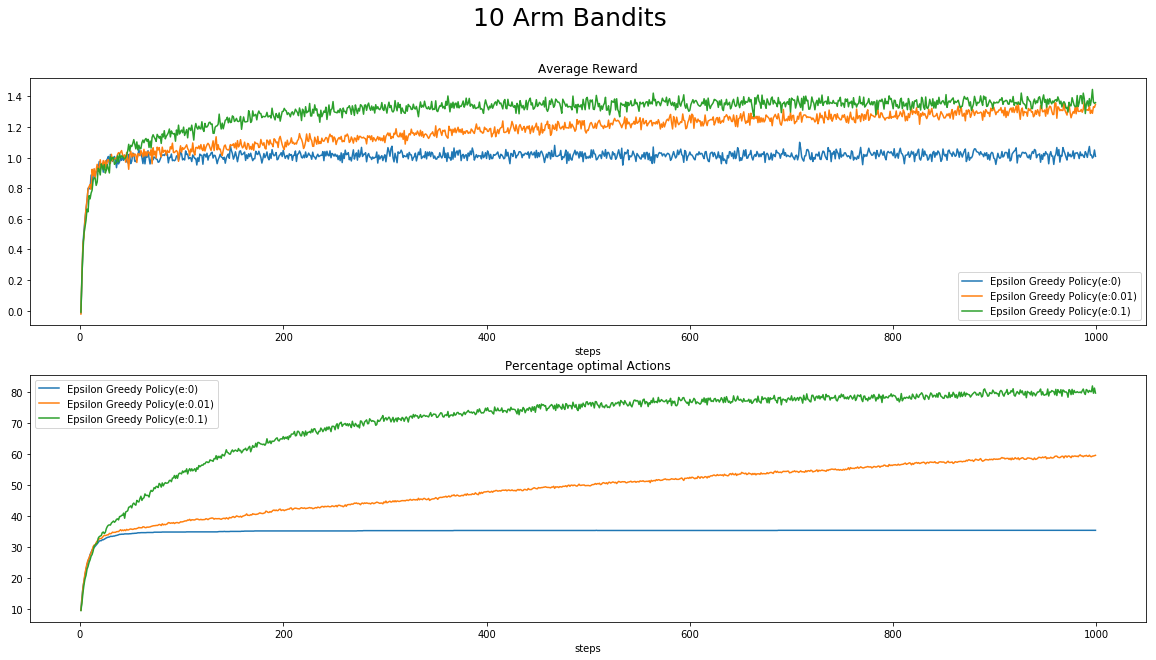

In [22]:
policies = [EpsilonGreedyPolicy((2000,10),0,0),EpsilonGreedyPolicy((2000,10),0,0.01),EpsilonGreedyPolicy((2000,10),0,0.1)];
optimal_arm = np.argmax(Model1.q_star,axis=-1);

fig, axs = plt.subplots(2,1,figsize=(20, 10))

for policy in policies:
    X=[];
    opt=[];
    ar =[];
    for step in np.arange(1,1000):
        A_arms = policy.pick_action();
        reward = Model1.pull(A_arms);
        policy.sa_update(reward,A_arms);
        no_opt =  np.sum(A_arms == optimal_arm);
        X.append(step);
        opt.append(no_opt*100/2000);
        ar.append(np.sum(reward)/np.size(reward));
    X=np.array(X);
    opt=np.array(opt);
    axs[1].plot(X,opt,label=policy.name) ;
    axs[0].plot(X,ar,label=policy.name) ;
    
axs[1].legend();
axs[1].set_title("Percentage optimal Actions");
axs[1].set_xlabel("steps");
axs[0].legend();
axs[0].set_title("Average Reward");
axs[0].set_xlabel("steps")
fig.suptitle('10 Arm Bandits',fontsize=25)
fig.savefig("10ABepsiongreedy",dpi=500)
fig.show

<bound method Figure.show of <Figure size 1440x720 with 2 Axes>>

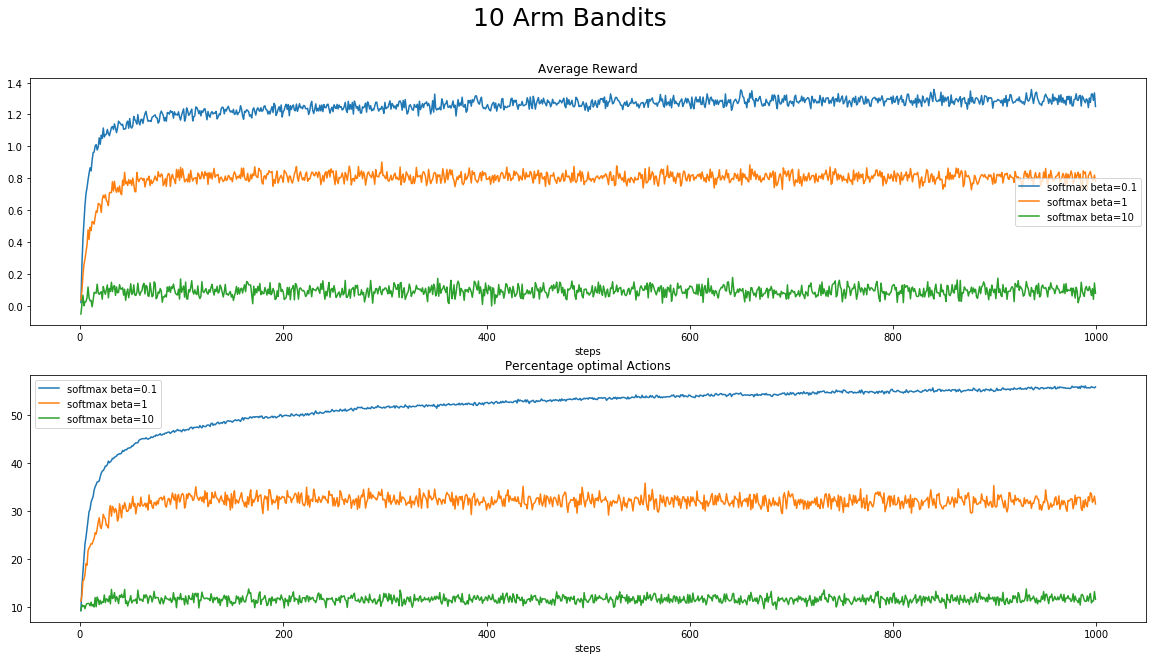

In [23]:
policies = [SoftmaxPolicy((2000,10),0,0.1),SoftmaxPolicy((2000,10),0,1),SoftmaxPolicy((2000,10),0,10)];
optimal_arm = np.argmax(Model1.q_star,axis=-1);

fig, axs = plt.subplots(2,1,figsize=(20, 10))

for policy in policies:
    X=[];
    opt=[];
    ar =[];
    for step in np.arange(1,1000):
        A_arms = policy.pick_action();
        reward = Model1.pull(A_arms);
        policy.sa_update(reward,A_arms);
        no_opt =  np.sum(A_arms == optimal_arm);
        X.append(step);
        opt.append(no_opt*100/2000);
        ar.append(np.sum(reward)/np.size(reward));
    X=np.array(X);
    opt=np.array(opt);
    axs[1].plot(X,opt,label=policy.name) ;
    axs[0].plot(X,ar,label=policy.name) ;
    
axs[1].legend();
axs[1].set_title("Percentage optimal Actions");
axs[1].set_xlabel("steps")
axs[0].legend();
axs[0].set_title("Average Reward");
axs[0].set_xlabel("steps");
fig.suptitle('10 Arm Bandits',fontsize=25)
fig.savefig("10ABSoftmax",dpi=500)
fig.show

<bound method Figure.show of <Figure size 1440x720 with 2 Axes>>

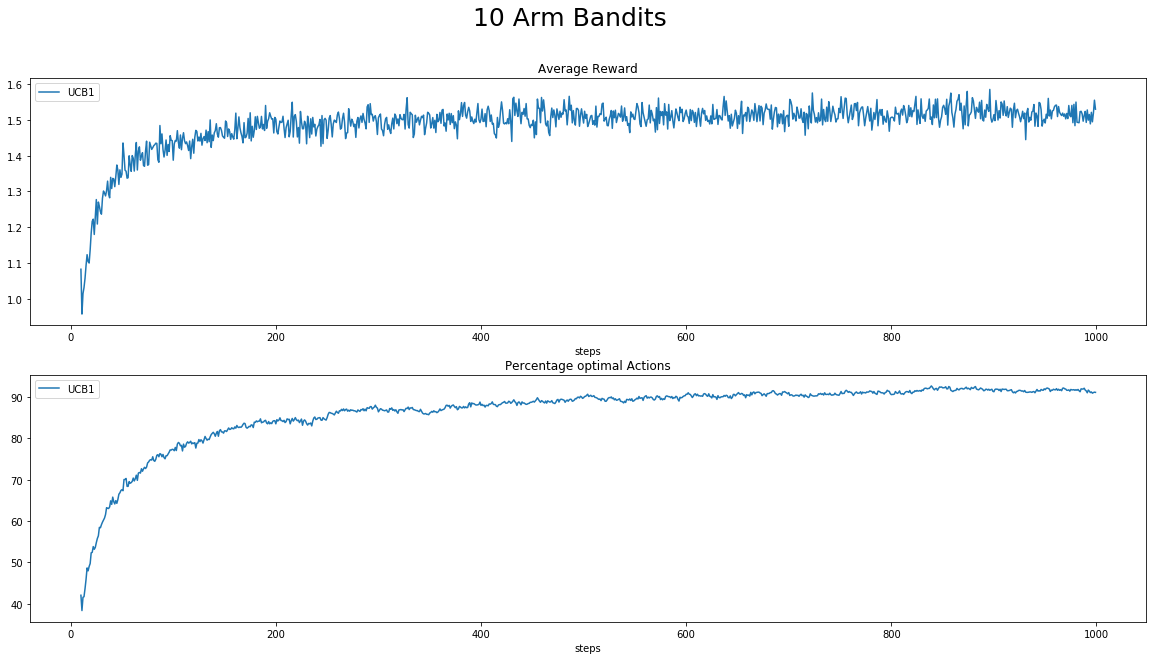

In [24]:
policies = [UCB1Policy((2000,10),model.q_star,model.reward_std)];
optimal_arm = np.argmax(Model1.q_star,axis=-1);

fig, axs = plt.subplots(2,1,figsize=(20, 10))

for policy in policies:
    X=[];
    opt=[];
    ar =[];
    for step in np.arange(policy.no_of_arms,1000):
        A_arms = policy.pick_action();
        reward = Model1.pull(A_arms);
        policy.sa_update(reward,A_arms);
        no_opt =  np.sum(A_arms == optimal_arm);
        X.append(step);
        opt.append(no_opt*100/2000);
        ar.append(np.sum(reward)/np.size(reward));
    X=np.array(X);
    opt=np.array(opt);
    axs[1].plot(X,opt,label=policy.name) ;
    axs[0].plot(X,ar,label=policy.name) ;
    
axs[1].legend();
axs[1].set_title("Percentage optimal Actions");
axs[1].set_xlabel("steps")
axs[0].legend();
axs[0].set_title("Average Reward");
axs[0].set_xlabel("steps")
fig.suptitle('10 Arm Bandits',fontsize=25)
fig.savefig("10ABUCB",dpi=500)
fig.show

# 1000 Arms Bandit

In [ ]:
Model2 = Bandit(bandit_size=(2000,1000),q_star_dist=(0,1),reward_std=1);

In [ ]:
policies = [EpsilonGreedyPolicy((2000,1000),0,0),EpsilonGreedyPolicy((2000,1000),0,0.01),EpsilonGreedyPolicy((2000,1000),0,0.1)];
optimal_arm = np.argmax(Model2.q_star,axis=-1);

fig, axs = plt.subplots(2,1,figsize=(20, 10))

for policy in policies:
    X=[];
    opt=[];
    ar =[];
    for step in np.arange(1,10000):
        A_arms = policy.pick_action();
        reward = Model2.pull(A_arms);
        policy.sa_update(reward,A_arms);
        no_opt =  np.sum(A_arms == optimal_arm);
        X.append(step);
        opt.append(no_opt*100/2000);
        ar.append(np.sum(reward)/np.size(reward));
    X=np.array(X);
    opt=np.array(opt);
    axs[1].plot(X,opt,label=policy.name) ;
    axs[0].plot(X,ar,label=policy.name) ;
    
axs[1].legend();
axs[1].set_title("Percentage optimal Actions");
axs[1].set_xlabel("steps")
axs[0].legend();
axs[0].set_title("Average Reward");
axs[0].set_xlabel("steps")
fig.suptitle('1000 Arm Bandits',fontsize=25)
fig.savefig("1000ABepsilongreedy",dpi=500)
fig.show

In [ ]:
policies = [SoftmaxPolicy((2000,1000),0,0.1),SoftmaxPolicy((2000,1000),0,1),SoftmaxPolicy((2000,1000),0,10)];
optimal_arm = np.argmax(Model2.q_star,axis=-1);

fig, axs = plt.subplots(2,1,figsize=(20, 10))

for policy in policies:
    X=[];
    opt=[];
    ar =[];
    for step in np.arange(1,10000):
        A_arms = policy.pick_action();
        reward = Model2.pull(A_arms);
        policy.sa_update(reward,A_arms);
        no_opt =  np.sum(A_arms == optimal_arm);
        X.append(step);
        opt.append(no_opt*100/2000);
        ar.append(np.sum(reward)/np.size(reward));
    X=np.array(X);
    opt=np.array(opt);
    axs[1].plot(X,opt,label=policy.name) ;
    axs[0].plot(X,ar,label=policy.name) ;
    
axs[1].legend();
axs[1].set_title("Percentage optimal Actions");
axs[1].set_xlabel("steps")
axs[0].legend();
axs[0].set_title("Average Reward");
axs[0].set_xlabel("steps");
fig.suptitle('1000 Arm Bandits',fontsize=25)
fig.savefig("1000ABSoftmax",dpi=500)
fig.show

In [ ]:
policies = [UCB1Policy((2000,1000),Model2.q_star,Model2.reward_std)];
optimal_arm = np.argmax(Model2.q_star,axis=-1);

fig, axs = plt.subplots(2,1,figsize=(20, 10))

for policy in policies:
    X=[];
    opt=[];
    ar =[];
    for step in np.arange(policy.no_of_arms,10000):
        A_arms = policy.pick_action();
        reward = Model2.pull(A_arms);
        policy.sa_update(reward,A_arms);
        no_opt =  np.sum(A_arms == optimal_arm);
        X.append(step);
        opt.append(no_opt*100/2000);
        ar.append(np.sum(reward)/np.size(reward));
    X=np.array(X);
    opt=np.array(opt);
    axs[1].plot(X,opt,label=policy.name) ;
    axs[0].plot(X,ar,label=policy.name) ;
    
axs[1].legend();
axs[1].set_title("Percentage optimal Actions");
axs[1].set_xlabel("steps")
axs[0].legend();
axs[0].set_title("Average Reward");
axs[0].set_xlabel("steps")
fig.suptitle('1000 Arm Bandits',fontsize=25)
fig.savefig("1000ABUCB",dpi=500)
fig.show